In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Import các thư viện cần thiết**

In [29]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

**2. Đọc file dữ liệu VPB và chia dataset theo tỉ lệ 6:3:1**

In [44]:
# Đọc file dữ liệu
df = pd.read_csv('/content/drive/MyDrive/StockData/HPG.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

**Xem** **lại** **dataset**

In [45]:
df

,Price
0,14831.7
1,15284.1
2,15560.7
3,15409.8
4,15233.9
...,...
1246,21350.0
1247,21200.0
1248,21400.0
1249,21600.0


**3. Dùng model ARIMA để train data**

In [32]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
# Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = False)
# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=11380.696, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=11218.767, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=11378.713, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=11137.541, Time=0.15 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=11086.325, Time=0.19 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=11055.818, Time=0.24 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=11038.017, Time=0.38 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=10912.114, Time=4.67 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=10911.429, Time=4.55 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=10910.893, Time=6.38 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.14 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.07 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=1

ARIMA(order=(4, 2, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

**4. Quá trình test**

In [39]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))


**5. Quá trình validate**

In [40]:
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

**6. Quá trình tạo index predict 30 ngày tiếp theo**

In [41]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[40771.41431563 40935.69752198 41347.77628993 41691.69770411
 41926.69326809 42199.4360246  42429.64043335 42721.52528775
 42964.89952338 43251.58189704 43496.21902425 43777.919181
 44026.51486643 44305.26366396 44556.9787431  44832.94376348
 45087.06536682 45360.81363525 45616.93120255 45888.89953493
 46146.62261714 46417.14678307 46676.16584999 46945.52471873
 47205.59130707 47474.00900782 47734.92148132 48002.57893446
 48264.17461745 48531.2180621 ]


***7.Đánh giá độ chính xác thuật toán***

In [42]:
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 37879.93375489616
Testing RMSE: 69419.30889150019
Validation MAPE: 178.1451388071275
Testing MAPE: 248.6937509814775
Validation MAE: 36837.82167379012
Testing MAE: 59232.21584987231


**8. Vẽ biểu đồ**

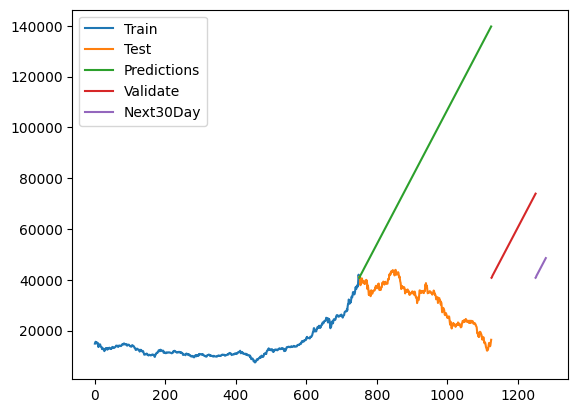

In [43]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()